In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import re
import os
import zlib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sys
import seaborn as sns
from sklearn.cluster import KMeans
import nltk
from langdetect import detect

ModuleNotFoundError: No module named 'langdetect'

In [2]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error 

In [3]:
Spotify = pd.read_csv('/Users/thomasdorveaux/Desktop/Fundation of Machine learning/Assignment 3/CodeML3/Machine_Learning_A3/SpotifyFeatures.csv')
lyrics = pd.read_csv('/Users/thomasdorveaux/Desktop/Fundation of Machine learning/Assignment 3/CodeML3/Machine_Learning_A3/only_lyrics.csv')

## Merging lyrics and the songs

In [4]:
Spotify['track_name']=Spotify['track_name'].str.lower()
Spotify['track_name']=Spotify['track_name'].str.strip()
Spotify['artist_name']=Spotify['artist_name'].str.lower()
Spotify['artist_name']=Spotify['artist_name'].str.strip()
lyrics['song']=lyrics['song'].str.lower()
lyrics['song']=lyrics['song'].str.strip()
lyrics['artist']=lyrics['artist'].str.lower()
lyrics['artist']=lyrics['artist'].str.strip()

In [5]:
song_lyrics = Spotify.merge(lyrics, left_on=['track_name', 'artist_name'], right_on=['song', 'artist'])  

In [6]:
song_lyrics =song_lyrics.sort_values(by=['popularity'],ascending=False)
song_lyrics = song_lyrics.reset_index()


In [7]:
song_lyrics=song_lyrics.drop(['index','artist', 'song', 'link'], axis=1)

In [8]:
#clean_lyrics(song_lyrics.iloc[675,-1])

## Pre-processing lyrics

In [9]:
def clean_lyrics(lyrics):
    new_lyrics = re.sub(r'[\(\[].*?[\)\]]', ' ', lyrics)
    new_lyrics = new_lyrics.replace("\n", " ")
    #new_lyrics = new_lyrics.replace(""\"","")
    new_lyrics= new_lyrics.strip()
    new_lyrics= new_lyrics.replace("    ", " ")
    new_lyrics= new_lyrics.replace("   ", " ")
    new_lyrics= new_lyrics.replace("  ", " ")
    new_lyrics = os.linesep.join([s for s in new_lyrics.splitlines() if s])
    return(new_lyrics)

In [10]:
def get_compression_rate(lyrics):
    original = lyrics.encode('utf-8')
    compressed = zlib.compress(original)
    decompressed = zlib.decompress(compressed)
    
    compression_rate = (len(original)-len(compressed))/len(original)
    return compression_rate

In [11]:
#Apply clean_lyrics function to text column
song_lyrics['text'] = song_lyrics['text'].map(clean_lyrics)

#Append new column with compression rate
song_lyrics['compression_rate'] = song_lyrics['text'].map(get_compression_rate)

In [12]:
#Drop duplicates
song_lyrics = song_lyrics.sort_values(by='popularity', ascending=False)
song_lyrics = song_lyrics.drop_duplicates(subset='track_id', keep="first")

#Keep only english songs
song_lyrics['language'] = song_lyrics['text'].map(detect)
song_lyrics = song_lyrics[song_lyrics['language'] =="en"]

NameError: name 'detect' is not defined

### Addition of sentment analysis (+,-,=) values

In [13]:
sia=SentimentIntensityAnalyzer()
sentiment = pd.DataFrame(columns=('id','senti_positive', 'senti_neutral', 'senti_negative'))
for i in range(len(song_lyrics['text'])):
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    lyric= song_lyrics.iloc[i,-2]
    for j in lyric.split():
        comp = sia.polarity_scores(j)
        comp = comp['compound']
        #print(test)
        if comp >= 0.5:
            num_positive += 1
            #print('positive:',i)
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        else:
            num_negative += 1
        #print('negative:',i)
    sentiment.loc[i] = (song_lyrics.iloc[i,3],num_positive,num_neutral,num_negative)
#num_total = num_negative + num_neutral + num_positive
#print('Total score:',num_total)
#print('Negative score:',num_negative)
#print('Neutral score:',num_neutral)
#print('Positive score:',num_positive)


In [14]:
#sentiment['senti_total']=sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']
sentiment['senti_%+']=(sentiment['senti_positive']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment['senti_%-']=(sentiment['senti_negative']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment['senti_%=']=(sentiment['senti_neutral']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100

In [15]:
sentiment['senti_total']=sentiment['senti_positive']-sentiment['senti_negative']

In [16]:
sentiment=sentiment.drop(['senti_positive','senti_neutral', 'senti_negative'], axis=1)

In [17]:
song_lyrics = song_lyrics.merge(sentiment, left_on=['track_id'], right_on=['id'])

In [18]:
song_lyrics=song_lyrics.drop(['id'], axis=1)

In [19]:
song=song_lyrics['track_name']
song=song.str.strip()
song=song.str.split()
l=[]
for i in song:
    #print(len(i))
    l.append(len(i))
song_lyrics['track_length']=l 

# Feature Engineering

1. Turning popularity into a class

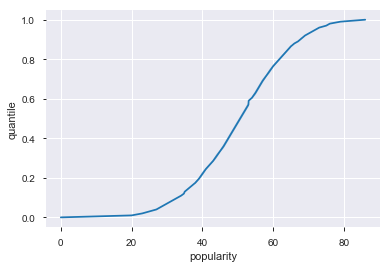

In [20]:
quantile=song_lyrics['popularity'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile=quantile.reset_index()
quantile.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile['popularity'],quantile['quantile'])

In [21]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(quantile)
quantile['cluster']=kmeans.predict(quantile)

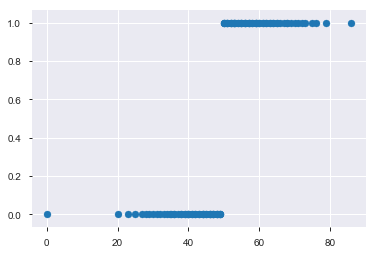

In [22]:
plt.scatter(quantile['popularity'],quantile['cluster'])

In [23]:
one=quantile[quantile.cluster==1]
#two=quantile[quantile.cluster==2]
#three=quantile[quantile.cluster==3]
zero=quantile[quantile.cluster==0]
#four=quantile[quantile.cluster==4]
min_one=np.min(one['popularity'])
max_one=np.max(one['popularity'])
#min_two=np.min(two['popularity'])
#max_two=np.max(two['popularity'])
#min_three=np.min(three['popularity'])
#max_three=np.max(three['popularity'])
min_zero=np.min(zero['popularity'])
max_zero=np.max(zero['popularity'])
#min_four=np.min(four['popularity'])
#max_four=np.max(four['popularity'])
print(1,min_one,max_one)
#print(2,min_two,max_two)
#print(3,min_three,max_three)
#print(4,min_four,max_four)
print(0,min_zero,max_zero)

1 50.0 86.0
0 0.0 49.0


In [24]:
conditions = [
    (song_lyrics['popularity'] >= 59)&(song_lyrics['popularity'] <=100),
    (song_lyrics['popularity'] >= 42)&(song_lyrics['popularity'] <=58),
    (song_lyrics['popularity'] >= 38)&(song_lyrics['popularity'] <=41),
    (song_lyrics['popularity'] >= 34)&(song_lyrics['popularity'] <=37),
    (song_lyrics['popularity'] >= 33)&(song_lyrics['popularity'] <=0)]
choices = [1,0,0,0,0]
song_lyrics['label'] = np.select(conditions, choices)

2. Turning acousticness into a class

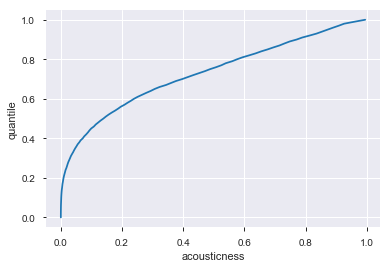

In [25]:
quantile_acou=song_lyrics['acousticness'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile_acou=quantile_acou.reset_index()
quantile_acou.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile_acou['acousticness'],quantile_acou['quantile'])

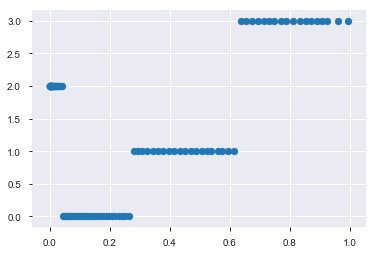

In [26]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(quantile_acou)
quantile_acou['cluster']=kmeans.predict(quantile_acou)
plt.scatter(quantile_acou['acousticness'],quantile_acou['cluster'])

In [27]:
zero=quantile_acou[quantile_acou.cluster==0]
one=quantile_acou[quantile_acou.cluster==1]
two=quantile_acou[quantile_acou.cluster==2]
three=quantile_acou[quantile_acou.cluster==3]
four=quantile_acou[quantile_acou.cluster==4]

min_zero=np.min(zero['acousticness'])
max_zero=np.max(zero['acousticness'])
min_one=np.min(one['acousticness'])
max_one=np.max(one['acousticness'])
min_two=np.min(two['acousticness'])
max_two=np.max(two['acousticness'])
min_three=np.min(three['acousticness'])
max_three=np.max(three['acousticness'])

print(0,min_zero,max_zero)
print(1,min_one,max_one)
print(2,min_two,max_two)
print(3,min_three,max_three)

0 0.043364000000000034 0.265
1 0.27899999999999997 0.6158599999999996
2 1.39e-06 0.04010900000000001
3 0.637 0.995


In [28]:
conditions_acou = [
    (song_lyrics['acousticness'] >= 0.6158599999999996)&(song_lyrics['acousticness'] <=0.995),
    (song_lyrics['acousticness'] >= 0.252)& (song_lyrics['acousticness'] <=0.594),
    (song_lyrics['acousticness'] >= 0.04010900000000002)&(song_lyrics['acousticness'] <=0.251),
    (song_lyrics['acousticness'] >= 0)&(song_lyrics['acousticness'] <=0.04010900000000001)]
choices_acou = [3, 2,1,0]
song_lyrics['label_acou'] = np.select(conditions_acou, choices_acou)
class_acou=song_lyrics['label_acou']

3. Analysing features distributions

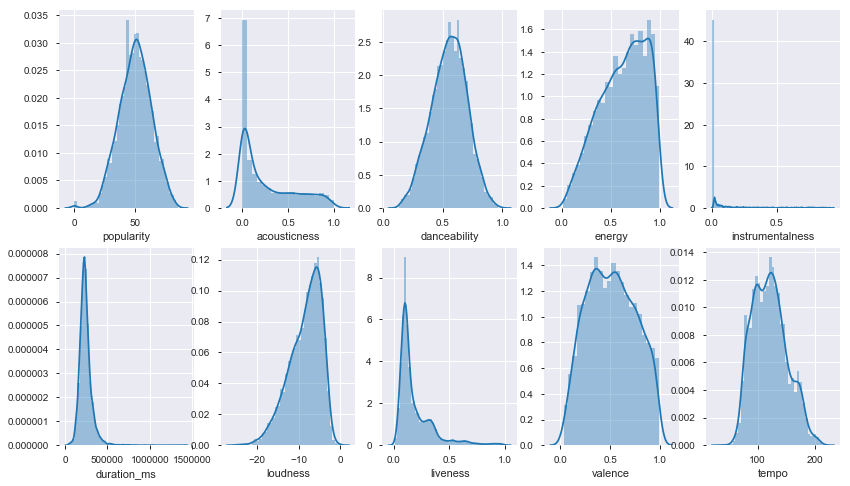

In [29]:
f, axes = plt.subplots(2, 5, figsize=(14, 8), sharex=False)
sns.distplot(song_lyrics['popularity'],ax=axes[0,0])
sns.distplot(song_lyrics['acousticness'],ax=axes[0,1])
sns.distplot(song_lyrics['danceability'],ax=axes[0,2])
sns.distplot(song_lyrics['energy'],ax=axes[0,3])
sns.distplot(song_lyrics['instrumentalness'],ax=axes[0, 4])
sns.distplot(song_lyrics['liveness'],ax=axes[1,2])
sns.distplot(song_lyrics['loudness'],ax=axes[1,1])
sns.distplot(song_lyrics['duration_ms'],ax=axes[1,0])
sns.distplot(song_lyrics['valence'],ax=axes[1,3])
sns.distplot(song_lyrics['tempo'],ax=axes[1,4])

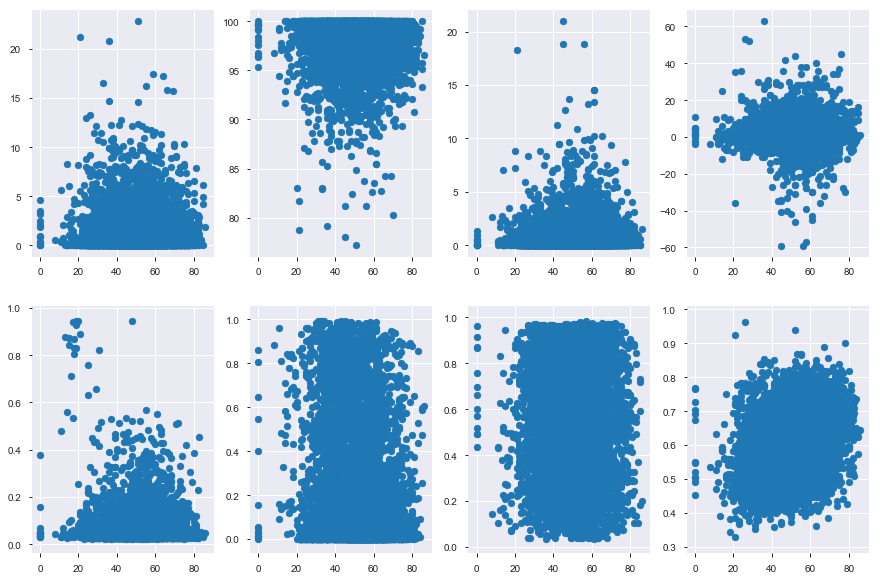

In [30]:
f, axes = plt.subplots(figsize=(15, 10), sharex=False)
ax = plt.subplot(2,4,1)
plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%+'])
ax = plt.subplot(2,4,2)
plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%='])
ax = plt.subplot(2,4,3)
plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%-'])
ax = plt.subplot(2,4,4)
plt.scatter(song_lyrics['popularity'],song_lyrics['senti_total'])
ax = plt.subplot(2,4,5)
plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'])
ax = plt.subplot(2,4,6)
plt.scatter(song_lyrics['popularity'],song_lyrics['acousticness'])
ax = plt.subplot(2,4,7)
plt.scatter(song_lyrics['popularity'],song_lyrics['valence'])
ax = plt.subplot(2,4,8)
plt.scatter(song_lyrics['popularity'],song_lyrics['compression_rate'])

In [31]:
#using logarithmic scaling on liveness and duration
ln_duration_ms = np.log(song_lyrics['duration_ms'])
ln_liveness = np.log(song_lyrics['liveness'])
#sns.distplot(ln_duration_ms,axlabel='ln(duration)' )
#sns.distplot(song_lyrics['liveness'])
#sns.distplot(ln_liveness, axlabel='ln(liveness)')
#sns.distplot(song_lyrics['duration_ms'],axlabel='duration')

4. Encoding

In [32]:
# renaming data before classification

# track features
genre = song_lyrics['genre'].str.strip()
genre = song_lyrics['genre'].str.lower()
artist_name = song_lyrics['artist_name'].str.strip()
artist_name = song_lyrics['artist_name'].str.lower()
track_name = song_lyrics['track_name']
track_id = song_lyrics['track_id']

# spotify features
popularity = song_lyrics['popularity']
acousticness = song_lyrics['acousticness']
danceability = song_lyrics['danceability']
duration_ms = song_lyrics['duration_ms']
energy = song_lyrics ['energy']
instrumentalness = song_lyrics['instrumentalness']
key = song_lyrics['key']
liveness = song_lyrics['liveness']
loudness = song_lyrics['loudness']
mode = song_lyrics['mode']
speechiness = song_lyrics['speechiness']
tempo = song_lyrics['tempo']
time_signature = song_lyrics['time_signature']
valence = song_lyrics['valence']

# sentimental features
text = song_lyrics['text']
compression_rate = song_lyrics['compression_rate']
senti_positive = song_lyrics['senti_%+']
senti_neutral = song_lyrics['senti_%=']
senti_negative = song_lyrics['senti_%-']
senti_total = song_lyrics['senti_total']

In [33]:
# encoding discrete data

# track features
genre_encoded = pd.get_dummies(genre,prefix='genre', dummy_na=False)
artist_name_encoded = pd.get_dummies(artist_name,prefix='artist_name', dummy_na=False)

# spotify features 
key_encoded = pd.get_dummies(key,prefix='key', dummy_na=False)
mode_encoded = pd.get_dummies(mode,prefix='mode', dummy_na=False)
time_signature_encoded = pd.get_dummies(time_signature,prefix='time_signature', dummy_na=False)
class_acou_encoded = pd.get_dummies(class_acou,prefix='label_acou', dummy_na=False)

In [34]:
final_num=pd.DataFrame({'track_length':song_lyrics['track_length'],'compression_rate':compression_rate,'danceability':danceability,'duration_ms':duration_ms,'energy':energy,'instrumentalness':instrumentalness,'liveness':liveness,'loudness':loudness,'speechiness':speechiness,'tempo':tempo, 'valence':valence,'senti_%+':senti_positive, 'senti_%=':senti_neutral,'senti_%-':senti_negative, 'senti_total':senti_total })
final_encode=pd.concat([class_acou_encoded,key_encoded,mode_encoded,time_signature_encoded,genre_encoded,artist_name_encoded],axis=1)
Features=pd.concat([final_num,final_encode],axis=1)
Label=song_lyrics['label']

In [35]:
Features.shape

(5274, 475)

In [36]:
Label=song_lyrics['label']

In [37]:
Label=Label.fillna(0)

In [38]:
Spotify = pd.concat((Features,Label),axis=1)
#Spotify = Spotify.drop(Spotify.columns[0], axis=1)

In [39]:
training = Spotify.sample(frac = 0.8,random_state = 1)

X_train = training.loc[:, training.columns != 'label']
y_train = training['label']
X_test = Spotify.drop(training.index).loc[:, training.columns != 'label']
y_test = Spotify.drop(training.index)['label']

In [40]:
X_train.shape

(4219, 475)

In [41]:
Num_Features = ['track_length', 'compression_rate', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'senti_%+', 'senti_%=', 'senti_%-',
       'senti_total', 'duration_min', 'len_track_name']
Lyric_Features = ['track_length','compression_rate', 'senti_%+', 'senti_%=', 'senti_%-','senti_total','len_track_name']

In [42]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selector.fit(X_train)
variance_features = X_train[X_train.columns[selector.get_support(indices=True)]].columns
variance_features

Index(['track_length', 'duration_ms', 'loudness', 'tempo', 'senti_%+',
       'senti_%=', 'senti_%-', 'senti_total', 'label_acou_0', 'label_acou_1',
       'label_acou_2', 'label_acou_3', 'key_A', 'key_C', 'key_G', 'mode_Major',
       'mode_Minor', 'genre_rock'],
      dtype='object')

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train1 = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
#negative values (loudness, sentiment score) are taken out to use chi2

selector = SelectKBest(chi2, k=50)
selector.fit(X_train1,y_train)
Chi2_features = X_train1[X_train1.columns[selector.get_support(indices=True)]].columns
Chi2_features

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Index(['instrumentalness', 'label_acou_3', 'genre_alternative', 'genre_blues',
       'genre_comedy', 'genre_country', 'genre_electronic', 'genre_folk',
       'genre_jazz', 'genre_pop', 'genre_rap', 'genre_reggae', 'genre_rock',
       'genre_ska', 'genre_world', 'artist_name_adam sandler',
       'artist_name_adele', 'artist_name_aerosmith',
       'artist_name_ariana grande', 'artist_name_billie holiday',
       'artist_name_bruno mars', 'artist_name_coldplay',
       'artist_name_creedence clearwater revival', 'artist_name_drake',
       'artist_name_ed sheeran', 'artist_name_elvis presley',
       'artist_name_face to face', 'artist_name_green day',
       'artist_name_journey', 'artist_name_justin bieber',
       'artist_name_kanye west', 'artist_name_kenny chesney',
       'artist_name_linkin park', 'artist_name_lorde', 'artist_name_maroon 5',
       'artist_name_michael jackson', 'artist_name_nofx',
       'artist_name_one direction', 'artist_name_phish',
       'artist_name_qu

In [44]:
clf = RandomForestClassifier(n_estimators=1000, random_state=1)
clf.fit(X_train, y_train)

feat_labels = X_train.columns
Importance = []
for feature in zip(feat_labels, clf.feature_importances_):
    Importance.append(feature)

sorted_by_importance = sorted(Importance, key=lambda tup: tup[1], reverse=True)
RandomForest_features = sorted_by_importance[0:50]
RandomForest_features_list = [x[0] for x in RandomForest_features]
RandomForest_features_list

['genre_pop',
 'genre_rock',
 'compression_rate',
 'loudness',
 'duration_ms',
 'energy',
 'danceability',
 'valence',
 'speechiness',
 'tempo',
 'liveness',
 'senti_%=',
 'instrumentalness',
 'senti_%+',
 'senti_total',
 'senti_%-',
 'track_length',
 'genre_blues',
 'artist_name_drake',
 'genre_country',
 'genre_rap',
 'label_acou_1',
 'label_acou_0',
 'mode_Major',
 'mode_Minor',
 'key_C',
 'label_acou_2',
 'genre_dance',
 'key_G',
 'key_A',
 'key_D',
 'label_acou_3',
 'artist_name_one direction',
 'key_B',
 'key_C#',
 'artist_name_twenty one pilots',
 'key_F',
 'key_E',
 'genre_folk',
 'key_F#',
 'genre_children’s music',
 'key_G#',
 'key_A#',
 'genre_ska',
 'genre_reggae',
 'genre_r&b',
 'artist_name_adele',
 'time_signature_4/4',
 'artist_name_red hot chili peppers',
 'artist_name_coldplay']

In [45]:
from sklearn.feature_selection import RFE

estimator = LogisticRegression(penalty='l2',solver='lbfgs',max_iter = 10000)
selector = RFE(estimator, 50, step=5)

selector.fit(X_train,y_train)
RFE_features = X_train[X_train.columns[selector.get_support(indices=True)]].columns
RFE_features

Index(['compression_rate', 'instrumentalness', 'genre_alternative',
       'genre_blues', 'genre_classical', 'genre_country', 'genre_electronic',
       'genre_pop', 'genre_rap', 'genre_reggae', 'genre_rock', 'genre_world',
       'artist_name_adele', 'artist_name_aerosmith',
       'artist_name_ariana grande', 'artist_name_bruno mars',
       'artist_name_chuck berry', 'artist_name_coldplay',
       'artist_name_creedence clearwater revival', 'artist_name_drake',
       'artist_name_elvis presley', 'artist_name_europe',
       'artist_name_face to face', 'artist_name_green day',
       'artist_name_jim croce', 'artist_name_jimmy buffett',
       'artist_name_journey', 'artist_name_justin bieber',
       'artist_name_keith urban', 'artist_name_kirk franklin',
       'artist_name_lorde', 'artist_name_luther vandross',
       'artist_name_marilyn manson', 'artist_name_nicki minaj',
       'artist_name_nofx', 'artist_name_one direction', 'artist_name_outkast',
       'artist_name_queen', 

In [46]:
All_features = variance_features.values.tolist()+Chi2_features.values.tolist()+RandomForest_features_list+RFE_features.values.tolist()
Features_selected = set(All_features)
print(len(All_features))
print(len(Features_selected))

from collections import Counter
Counter(All_features).most_common(46)

all_features = X_train.columns

168
100


[0.72576832 0.72576832 0.72576832 0.72576832 0.72511848 0.72684086
 0.72684086 0.72684086 0.72684086 0.72684086]
0.7262396044998775
Accuracy: 0.7374407582938388


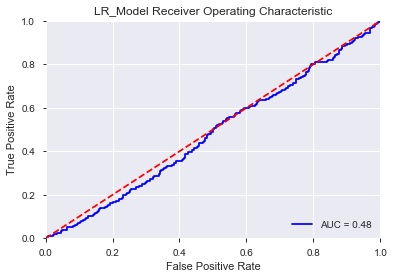

[0.81560284 0.81560284 0.80378251 0.82978723 0.81042654 0.82660333
 0.78859857 0.79334917 0.80047506 0.80997625]
0.8094204329292856
Accuracy: 0.7819905213270142


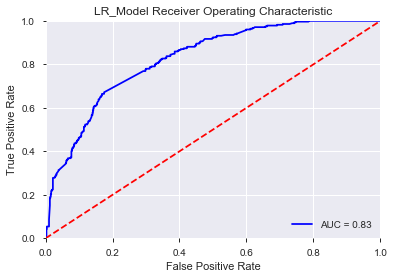

[0.72576832 0.72576832 0.72576832 0.72576832 0.72511848 0.72684086
 0.72684086 0.72684086 0.72684086 0.72684086]
0.7262396044998775
Accuracy: 0.7374407582938388


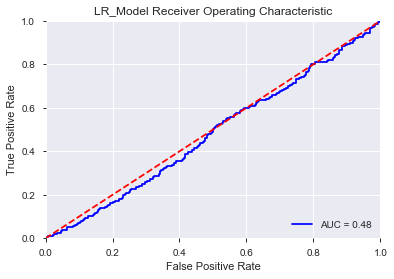

[0.82033097 0.82742317 0.81323877 0.82269504 0.82701422 0.83847981
 0.80760095 0.80760095 0.80997625 0.81235154]
0.8186711662459538
Accuracy: 0.7933649289099526


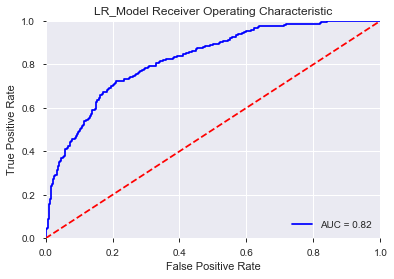

[0.72576832 0.72576832 0.72576832 0.72576832 0.72511848 0.72684086
 0.72684086 0.72684086 0.72684086 0.72684086]
0.7262396044998775
Accuracy: 0.7374407582938388


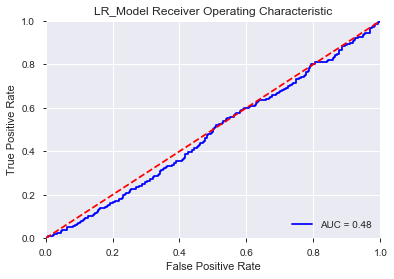

In [47]:
#Logistic regression
LR_Model = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter = 10000)

features = [variance_features, Chi2_features, RandomForest_features_list, RFE_features,all_features]

for feature in features:

    #CV score
    CV_scores = cross_val_score(LR_Model, X_train[feature], y_train, cv=10,scoring='accuracy')
    print(CV_scores)
    print(CV_scores.mean())

    #Predict test set
    LR_Model.fit(X_train[feature], y_train)
    LR_Predict = LR_Model.predict(X_test[feature])
    LR_Accuracy = accuracy_score(y_test, LR_Predict)
    print("Accuracy: " + str(LR_Accuracy))

    # calculate the fpr and tpr for all thresholds of the classification
    probs = LR_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('LR_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


[0.72813239 0.74231678 0.73522459 0.74468085 0.74881517 0.74821853
 0.73396675 0.73871734 0.73634204 0.72209026]
0.7378504692670463
Accuracy: 0.7184834123222749


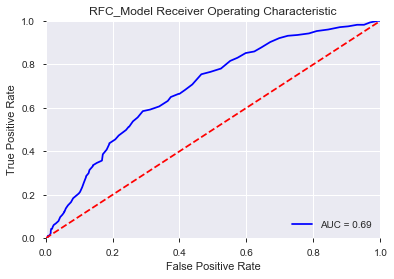

[0.79905437 0.77541371 0.78014184 0.81323877 0.74170616 0.78622328
 0.75059382 0.7719715  0.77672209 0.78384798]
0.7778913530734762
Accuracy: 0.7592417061611374


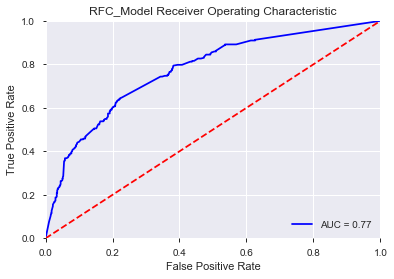

[0.78723404 0.81560284 0.80614657 0.82269504 0.80805687 0.8456057
 0.80760095 0.78859857 0.81710214 0.79334917]
0.8091991891102058
Accuracy: 0.7933649289099526


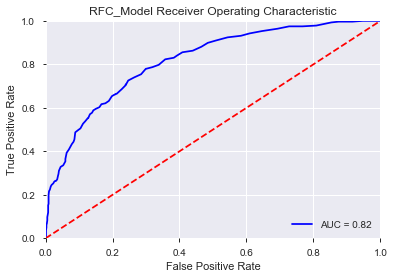

[0.78486998 0.79905437 0.80614657 0.78250591 0.74881517 0.81235154
 0.78384798 0.75059382 0.77672209 0.79097387]
0.7835881309191973
Accuracy: 0.7819905213270142


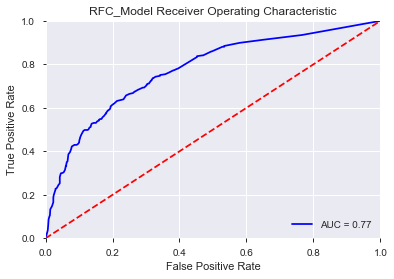

[0.79905437 0.82033097 0.78723404 0.81560284 0.80805687 0.83847981
 0.81235154 0.7695962  0.82185273 0.79334917]
0.8065908547941847
Accuracy: 0.7971563981042654


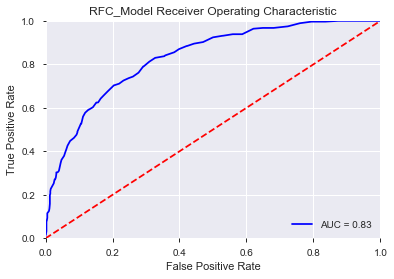

In [48]:
#Random Forest Classifier
RFC_Model = RandomForestClassifier(n_estimators=100)

for feature in features:
    #CV score
    CV_scores = cross_val_score(RFC_Model, X_train[feature], y_train, cv=10)
    print(CV_scores)
    print(CV_scores.mean())

    #Predict test set
    RFC_Model.fit(X_train[feature], y_train)
    RFC_Predict = RFC_Model.predict(X_test[feature])
    RFC_Accuracy = accuracy_score(y_test, RFC_Predict)
    print("Accuracy: " + str(RFC_Accuracy))

    # calculate the fpr and tpr for all thresholds of the classification
    probs = RFC_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('RFC_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [49]:
#KNN Classifier, 
KNN_accuracy = []
for i in range(1,20):
    KNN_Model = KNeighborsClassifier(n_neighbors=i)

    #CV score
    CV_scores = cross_val_score(KNN_Model, X_train, y_train, cv=10)
    KNN_accuracy.append(CV_scores.mean())
print(KNN_accuracy) 

#Predict test set
KNN_Model = KNeighborsClassifier(n_neighbors=7)
KNN_Model.fit(X_train, y_train)

KNN_Predict = KNN_Model.predict(X_test)
KNN_Accuracy = accuracy_score(y_test, KNN_Predict)
print("Accuracy: " + str(KNN_Accuracy))

[0.6114959801081092, 0.6878401194416162, 0.6361771507949873, 0.6944819635596192, 0.6608184617466166, 0.702066054294455, 0.6790633064676987, 0.7049018079939453, 0.6935183519650151, 0.7082232862662448, 0.6982717521381544, 0.7120203921101489, 0.7053819145463164, 0.7148640099737293, 0.7103571187437947, 0.7155732298318855, 0.7096484670748207, 0.7174723442897507, 0.7129677018647756]
Accuracy: 0.7071090047393365


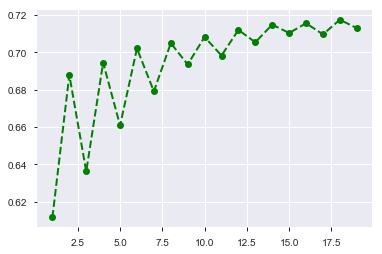

In [50]:
x=[i for i in range(1,20)]
plt.plot(x,KNN_accuracy , 'go--', linewidth=2)

[0.6114959801081092, 0.6878401194416162, 0.6361771507949873, 0.6944819635596192, 0.6608184617466166, 0.702066054294455, 0.6790633064676987, 0.7049018079939453, 0.6935183519650151, 0.7082232862662448, 0.6982717521381544, 0.7120203921101489, 0.7053819145463164, 0.7148640099737293, 0.7103571187437947, 0.7155732298318855, 0.7096484670748207, 0.7174723442897507, 0.7129677018647756, 0.7120203921101489]
Accuracy: 0.7071090047393365


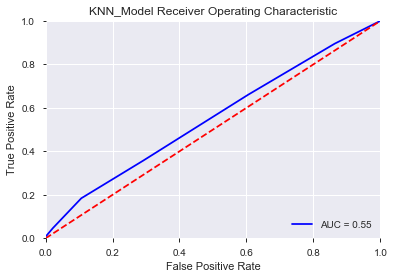

[0.6114959801081092, 0.6878401194416162, 0.6361771507949873, 0.6944819635596192, 0.6608184617466166, 0.702066054294455, 0.6790633064676987, 0.7049018079939453, 0.6935183519650151, 0.7082232862662448, 0.6982717521381544, 0.7120203921101489, 0.7053819145463164, 0.7148640099737293, 0.7103571187437947, 0.7155732298318855, 0.7096484670748207, 0.7174723442897507, 0.7129677018647756, 0.7120203921101489, 0.8001792443924852]
Accuracy: 0.7800947867298578


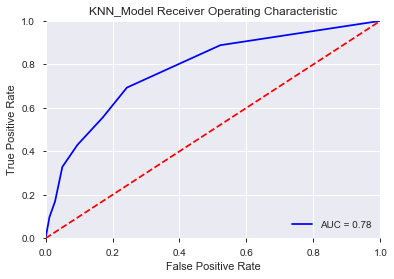

[0.6114959801081092, 0.6878401194416162, 0.6361771507949873, 0.6944819635596192, 0.6608184617466166, 0.702066054294455, 0.6790633064676987, 0.7049018079939453, 0.6935183519650151, 0.7082232862662448, 0.6982717521381544, 0.7120203921101489, 0.7053819145463164, 0.7148640099737293, 0.7103571187437947, 0.7155732298318855, 0.7096484670748207, 0.7174723442897507, 0.7129677018647756, 0.7120203921101489, 0.8001792443924852, 0.6790633064676987]
Accuracy: 0.7071090047393365


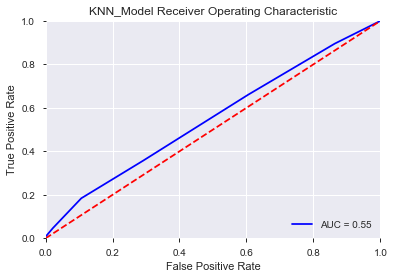

[0.6114959801081092, 0.6878401194416162, 0.6361771507949873, 0.6944819635596192, 0.6608184617466166, 0.702066054294455, 0.6790633064676987, 0.7049018079939453, 0.6935183519650151, 0.7082232862662448, 0.6982717521381544, 0.7120203921101489, 0.7053819145463164, 0.7148640099737293, 0.7103571187437947, 0.7155732298318855, 0.7096484670748207, 0.7174723442897507, 0.7129677018647756, 0.7120203921101489, 0.8001792443924852, 0.6790633064676987, 0.8070473848221313]
Accuracy: 0.7867298578199052


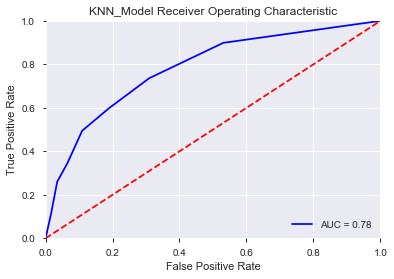

[0.6114959801081092, 0.6878401194416162, 0.6361771507949873, 0.6944819635596192, 0.6608184617466166, 0.702066054294455, 0.6790633064676987, 0.7049018079939453, 0.6935183519650151, 0.7082232862662448, 0.6982717521381544, 0.7120203921101489, 0.7053819145463164, 0.7148640099737293, 0.7103571187437947, 0.7155732298318855, 0.7096484670748207, 0.7174723442897507, 0.7129677018647756, 0.7120203921101489, 0.8001792443924852, 0.6790633064676987, 0.8070473848221313, 0.6790633064676987]
Accuracy: 0.7071090047393365


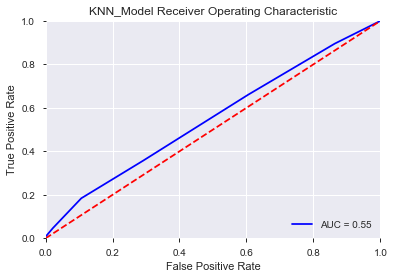

In [51]:
KNN_Model = KNeighborsClassifier(n_neighbors=12)

for feature in features:
    #CV score
    CV_scores = cross_val_score(KNN_Model, X_train[feature], y_train, cv=10)
    KNN_accuracy.append(CV_scores.mean())
    print(KNN_accuracy) 

    #Predict test set
    KNN_Model = KNeighborsClassifier(n_neighbors=7)
    KNN_Model.fit(X_train[feature], y_train)

    KNN_Predict = KNN_Model.predict(X_test[feature])
    KNN_Accuracy = accuracy_score(y_test, KNN_Predict)
    print("Accuracy: " + str(KNN_Accuracy))
    
    # calculate the fpr and tpr for all thresholds of the classification
    probs = KNN_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('KNN_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[0.72104019 0.74704492 0.76359338 0.76122931 0.73222749 0.75296912
 0.72684086 0.75059382 0.72921615 0.75296912]
0.7437724363204302
Accuracy: 0.7355450236966825


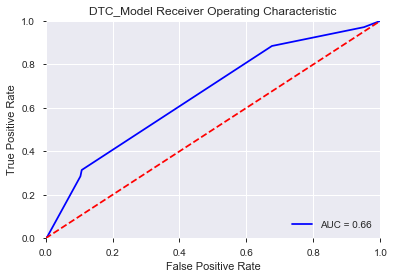

[0.78014184 0.80614657 0.8108747  0.8250591  0.79146919 0.81235154
 0.77909739 0.79334917 0.78384798 0.79572447]
0.7978061962853309
Accuracy: 0.7924170616113744


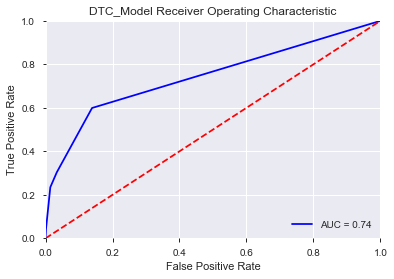

[0.78014184 0.80614657 0.8108747  0.8250591  0.78672986 0.81235154
 0.77909739 0.79334917 0.77909739 0.79572447]
0.7968572032536189
Accuracy: 0.7924170616113744


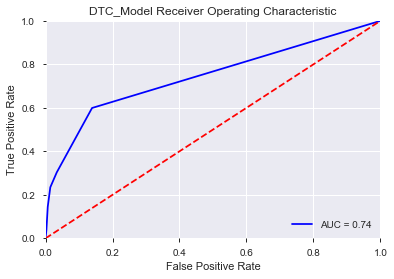

[0.78014184 0.80614657 0.80851064 0.82269504 0.78672986 0.81235154
 0.77672209 0.79334917 0.78384798 0.79572447]
0.7966219197060596
Accuracy: 0.7914691943127962


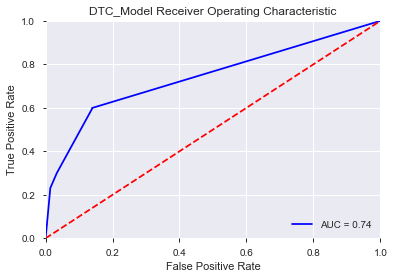

[0.78014184 0.80614657 0.8108747  0.82269504 0.78672986 0.81235154
 0.77909739 0.78859857 0.77909739 0.79572447]
0.7961457372518107
Accuracy: 0.790521327014218


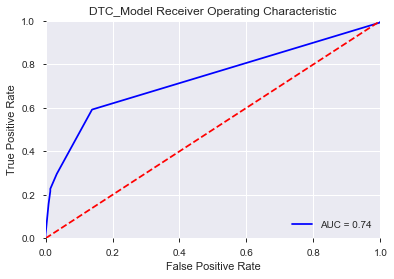

In [52]:
#DecisionTree Classifier
DTC_Model = DecisionTreeClassifier(criterion="entropy", max_depth=3)

for feature in features:
    #CV score
    CV_scores = cross_val_score(DTC_Model, X_train[feature], y_train, cv=10)
    print(CV_scores)
    print(CV_scores.mean())

    #Predict test set
    DTC_Model.fit(X_train[feature], y_train)

    DTC_Predict = DTC_Model.predict(X_test[feature])
    DTC_Accuracy = accuracy_score(y_test, DTC_Predict)
    print("Accuracy: " + str(DTC_Accuracy))

    # calculate the fpr and tpr for all thresholds of the classification
    probs = DTC_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('DTC_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[0.72576832 0.72576832 0.72576832 0.72576832 0.72511848 0.72684086
 0.72684086 0.72684086 0.72684086 0.72684086]
0.7262396044998775
Accuracy: 0.7374407582938388


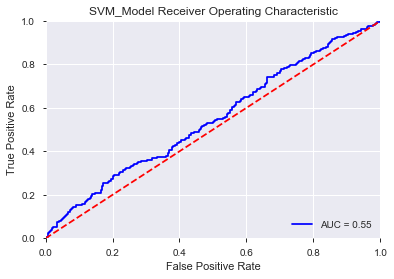

[0.79905437 0.79669031 0.80614657 0.8250591  0.80094787 0.82422803
 0.78859857 0.78859857 0.79809976 0.78384798]
0.8011271143523709
Accuracy: 0.7914691943127962


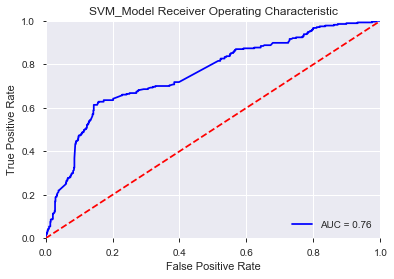

[0.72576832 0.72576832 0.72576832 0.72576832 0.72511848 0.72684086
 0.72684086 0.72684086 0.72684086 0.72684086]
0.7262396044998775
Accuracy: 0.7374407582938388


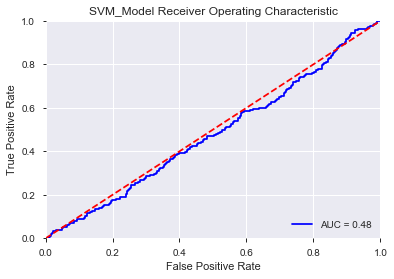

[0.80378251 0.8250591  0.80378251 0.8250591  0.81753555 0.8456057
 0.80760095 0.81947743 0.80760095 0.80760095]
0.8163104745901938
Accuracy: 0.7914691943127962


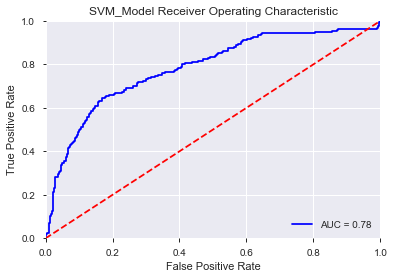

[0.72576832 0.72576832 0.72576832 0.72576832 0.72511848 0.72684086
 0.72684086 0.72684086 0.72684086 0.72684086]
0.7262396044998775
Accuracy: 0.7374407582938388


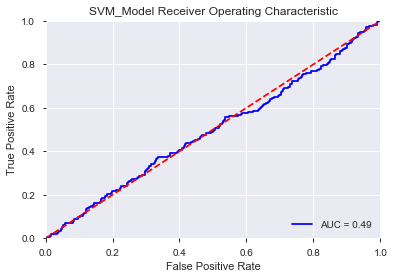

In [53]:
#SVM Classifier 
#to test different kernels = ['linear', 'rbf', 'sigmoid']
SVM_Model = svm.SVC(C=2,kernel='rbf',gamma='scale',decision_function_shape='ovr',probability=True)

for feature in features:
    #CV score
    CV_scores = cross_val_score(SVM_Model, X_train[feature], y_train, cv=10)
    print(CV_scores)
    print(CV_scores.mean())

    #Predict test set
    SVM_Model.fit(X_train[feature], y_train)

    SVM_Predict = SVM_Model.predict(X_test[feature])
    SVM_Accuracy = accuracy_score(y_test, SVM_Predict)
    print("Accuracy: " + str(SVM_Accuracy))

    # calculate the fpr and tpr for all thresholds of the classification
    probs = SVM_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('SVM_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[0.73049645 0.73286052 0.73049645 0.74940898 0.73696682 0.75059382
 0.72446556 0.72684086 0.71496437 0.73634204]
0.7333435886823422
Accuracy: 0.7402843601895734


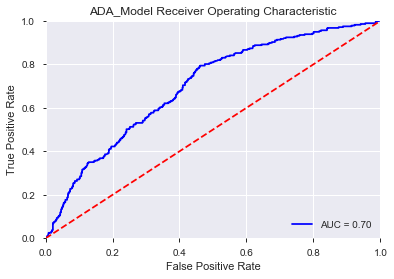

[0.8108747  0.8108747  0.80851064 0.8392435  0.81516588 0.81947743
 0.78147268 0.79572447 0.79097387 0.82185273]
0.8094170610524998
Accuracy: 0.785781990521327


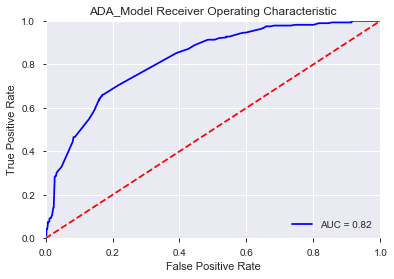

[0.8250591  0.77777778 0.80141844 0.80851064 0.82464455 0.82660333
 0.78384798 0.77672209 0.79809976 0.80997625]
0.8032659913385614
Accuracy: 0.7867298578199052


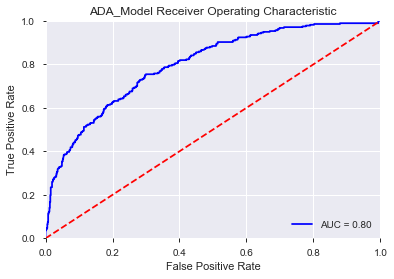

[0.82742317 0.8108747  0.80851064 0.83687943 0.83175355 0.8432304
 0.79334917 0.78384798 0.80760095 0.81947743]
0.8162947436007061
Accuracy: 0.7876777251184834


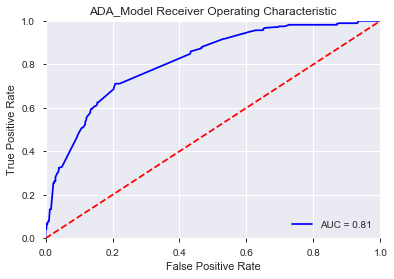

[0.82033097 0.78959811 0.80378251 0.8108747  0.81990521 0.83610451
 0.79809976 0.78147268 0.80285036 0.81472684]
0.8077745658455815
Accuracy: 0.7829383886255924


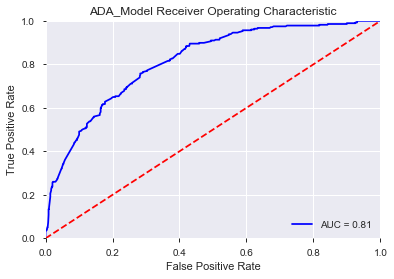

In [54]:
#Adaboosting Classifier
ADA_Model = AdaBoostClassifier(n_estimators=50,learning_rate=1)

for feature in features:
    #CV score
    CV_scores = cross_val_score(ADA_Model, X_train[feature], y_train, cv=10)
    print(CV_scores)
    print(CV_scores.mean())

    #Predict test set
    ADA_Model.fit(X_train[feature], y_train)

    ADA_Predict = ADA_Model.predict(X_test[feature])
    ADA_Accuracy = accuracy_score(y_test, ADA_Predict)
    print("Accuracy: " + str(ADA_Accuracy))

    # calculate the fpr and tpr for all thresholds of the classification
    probs = ADA_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ADA_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

[0.72340426 0.73995272 0.75177305 0.76832151 0.73933649 0.75771971
 0.71971496 0.75059382 0.71971496 0.75059382]
0.7421125321695541
Accuracy: 0.7497630331753554


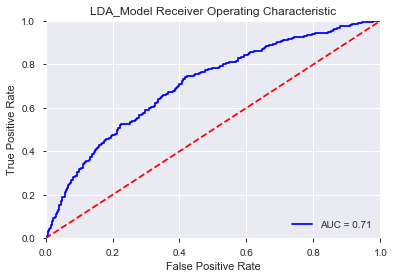

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

[0.81560284 0.79905437 0.8108747  0.82978723 0.8056872  0.82422803
 0.78147268 0.80047506 0.80522565 0.79809976]
0.8070507540376095
Accuracy: 0.7876777251184834


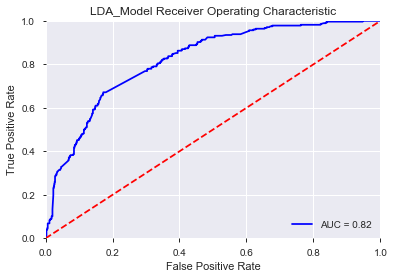

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

[0.82033097 0.80851064 0.80614657 0.8321513  0.79620853 0.83372922
 0.77672209 0.80047506 0.78622328 0.80997625]
0.8070473901447466
Accuracy: 0.7914691943127962


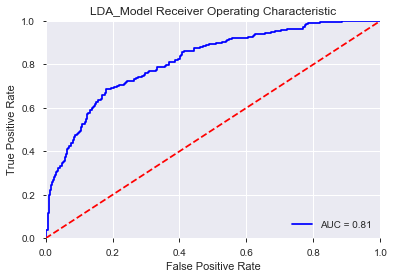

[0.82742317 0.81560284 0.8108747  0.84160757 0.83175355 0.847981
 0.79809976 0.80047506 0.82185273 0.82422803]
0.8219898408306495
Accuracy: 0.7943127962085308


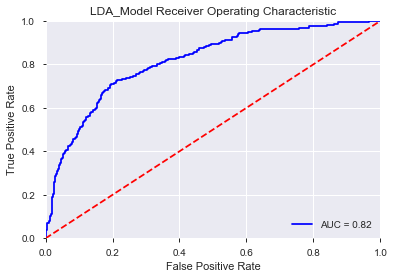

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

[0.82033097 0.79905437 0.80141844 0.8321513  0.81042654 0.83372922
 0.81947743 0.78622328 0.80760095 0.81235154]
0.8122764045829529


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy: 0.8018957345971564


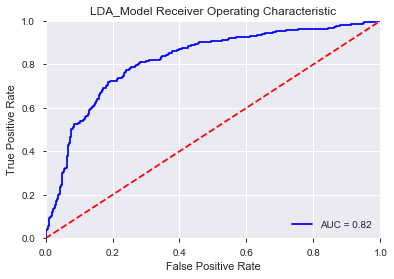

In [55]:
#LDA Classifier 
#Need to define number of components
LDA_Model = LinearDiscriminantAnalysis(n_components=2)

for feature in features:
    #CV score
    CV_scores = cross_val_score(LDA_Model, X_train[feature], y_train, cv=10)
    print(CV_scores)
    print(CV_scores.mean())

    #Predict test set
    LDA_Model.fit(X_train[feature], y_train)

    LDA_Predict = LDA_Model.predict(X_test[feature])
    LDA_Accuracy = accuracy_score(y_test, LDA_Predict)
    print("Accuracy: " + str(LDA_Accuracy))
    
    # calculate the fpr and tpr for all thresholds of the classification
    probs = LDA_Model.predict_proba(X_test[feature])
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('LDA_Model Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()